In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from torch.nn import functional as F
from torch.nn import Sequential, Tanh, Parameter
import mlflow as mlflow
%matplotlib inline

In [66]:
#!curl https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -o ../datasets/llm/shakeshpere.txt

In [67]:
torch.manual_seed(12345)
shakspheredata= open("input.txt",mode="r",encoding="utf8").read()

In [68]:
torch.manual_seed(12345)
vocab = sorted(list(set(shakspheredata)))
print("".join(vocab))
n_vocab = len(vocab)

stoi = {k:v for v,k in enumerate(vocab)}
itos = {v:k for v,k in enumerate(vocab)}
encode = lambda x:[stoi[i] for i in x]
decode = lambda x: "".join([itos[i] for i in x])


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [69]:
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [70]:
#Data prep
torch.manual_seed(12345)
text = torch.tensor(encode(shakspheredata))
n = int(.9*len(text))
train = text[:n]
val = text[n:]

In [57]:
torch.manual_seed(12345)
block_size = 8
train[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [58]:
torch.manual_seed(12345)
sample = train[:block_size+1]
for x in range(block_size):
    print(f"context {sample[:x+1]} : {sample[x+1]}")

context tensor([18]) : 47
context tensor([18, 47]) : 56
context tensor([18, 47, 56]) : 57
context tensor([18, 47, 56, 57]) : 58
context tensor([18, 47, 56, 57, 58]) : 1
context tensor([18, 47, 56, 57, 58,  1]) : 15
context tensor([18, 47, 56, 57, 58,  1, 15]) : 47
context tensor([18, 47, 56, 57, 58,  1, 15, 47]) : 58


In [59]:
batch_size = 4
block_size = 8

In [60]:
torch.manual_seed(12345)
def get_batch(split):
    data = train if "train" else val
    ix =  torch.randint(len(data) - block_size ,(batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    return x,y

class BigramModel(nn.Module):
    def __init__(self,vocab):
        super().__init__()
        self.embedding_table = nn.Embedding(vocab,vocab)

    def forward(self,idx,target=None):
        logits = self.embedding_table(idx)
        if target == None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            loss = F.cross_entropy(logits,target.view(B*T))
        return logits,loss

    def generate(self,max_tokens,idx):
        for _ in range(max_tokens):
            logits,loss = self(idx)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,1)
            idx =torch.cat((idx,idx_next), dim=1)

        return idx

In [61]:
torch.manual_seed(12345)
batch_size = 32
block_size = 8
lrsloss = []
lossi = []
lr = 1e-3
model = BigramModel(n_vocab)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [62]:
torch.manual_seed(12345)
for i in range(200000):
    #forward pass
    # lr = 0.01 if i <100000 else 0.001
    # optimizer = torch.optim.SGD(Model.parameters(), lr=lr)
    xb,yb = get_batch("train")
    logits,loss = model(xb,yb)
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    #backpass
    optimizer.zero_grad(set_to_none= True)
    loss.backward()
    optimizer.step()
    # for p in model.parameters():
    #     p.grad = None
    # loss.backward()
    # for p in model.parameters():
    #     p.data += -lr*p.grad


        

print(F" Final loss: {loss.item():.4f}")

loss at 0/200000 4.6399
loss at 10000/200000 2.4995
loss at 20000/200000 2.4302
loss at 30000/200000 2.6304
loss at 40000/200000 2.4114
loss at 50000/200000 2.3805
loss at 60000/200000 2.4079
loss at 70000/200000 2.3796
loss at 80000/200000 2.4392
loss at 90000/200000 2.4177
loss at 100000/200000 2.5361
loss at 110000/200000 2.4080
loss at 120000/200000 2.3640
loss at 130000/200000 2.4394
loss at 140000/200000 2.4261
loss at 150000/200000 2.5096
loss at 160000/200000 2.3829
loss at 170000/200000 2.3807
loss at 180000/200000 2.4836
loss at 190000/200000 2.3674
 Final loss: 2.5822


In [63]:
torch.manual_seed(12345)
print(decode(model.generate(1000,idx = torch.zeros((1,1),dtype=torch.long))[0].tolist()))


S:

Tho thisoune il tom thin sthe tices y ie ghed

ARord, st gourr h de prewitoro medd d pa nteremeeneriswhe yote
Frvokenopapou ty DYow ake, I t hersthed fowhththo ve,


O:
had dndyo bot y.


Thth t, ton ce.
CLORBeveng ofe ande.
II t anchansbulleerr be al.
I abl wendawan f,
teed ss soulld thin RI:
North cte, inctaved t t mm w od RDI'teo pile, we put, y infrcavepig diththr; d, s mere ald d me viveatiathmede s u s LUCENoknd oucamsthince myser, t,

tinatlle his l icold; t: f ghut?
METE:
KIAs mousobeake fucorissithe hat g gr IShas d th thint,
CI hen,
CES:
Thy t cay!

Thellamat t b
Fincirs om, bileallergotoo wou wafr RDe, a tie ine thende t tof ce tyou ma an heeju me n:
Y mes whathil spowowik Youtid,-
An l aldan merestl
ANI
QUSodaspud tou I t tr oy ll ten

Fo civordean m ou asthanctist thes beat id, Th waiathait y Fon:
A:
S:
BICint t be INGLedeve, fodo,
Swinoraw I shave; heve blorienoo h as?

ABYOUsos n wis e telates idsairenddre ck
Welenm glif hotours hibous, ing picavis t a
VInt hasierma

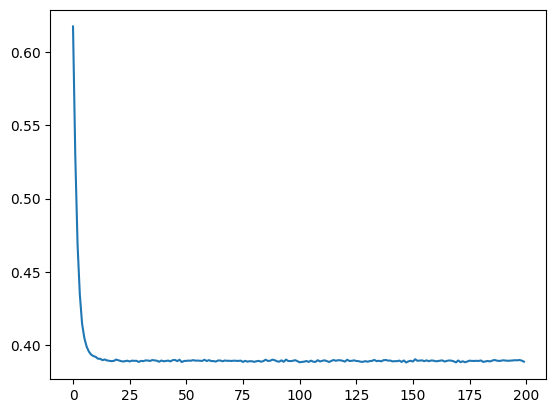

In [49]:
torch.manual_seed(12345)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

### Math trick in self attentionabs

In [317]:
torch.manual_seed(12346)
B,T,C = 4,8,32
x = torch.randn((B,T,C))

In [305]:
#multiplication with tril and sum
wei = torch.ones((T,T))
wei = wei.tril()
wei= wei/wei.sum(dim =1,keepdim=True)
out = wei @ x

In [306]:
out.shape

torch.Size([4, 8, 32])

In [307]:
a = torch.arange(1,10,dtype = torch.float)
a = a.view(3,3)
b= torch.ones(3,3,dtype = torch.float)
b=b.tril()
# b=b/b.sum(dim=1,keepdim=True)

In [308]:
wei = torch.ones((T,T))
wei = wei.tril()
wei=wei.masked_fill(wei==0,float('-inf'))
wei = torch.softmax(wei,dim=1)
# wei= wei/wei.sum(dim =1,keepdim=True)
out = wei @ x

In [309]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [215]:
out

tensor([[[-1.4798e+00,  4.8731e-01],
         [-2.2463e+00,  4.6558e-01],
         [-1.3776e+00,  3.0627e-01],
         [-9.7858e-01, -9.0664e-02],
         [-3.0063e-01,  3.2729e-01],
         [-1.1972e-01,  1.0283e-01],
         [-1.3270e-01,  1.7769e-01],
         [ 3.5568e-04,  1.7882e-01]],

        [[ 9.5893e-01, -1.1371e+00],
         [ 4.8012e-01,  9.0160e-02],
         [-1.8199e-02, -1.2085e-01],
         [ 9.4036e-02, -5.7205e-01],
         [ 3.3034e-01, -6.8395e-01],
         [ 4.1995e-01, -4.5198e-01],
         [ 3.8937e-01, -5.2027e-01],
         [ 3.5498e-01, -5.1087e-01]],

        [[-8.5306e-01, -8.4074e-01],
         [-6.2469e-01, -5.4994e-01],
         [-6.4223e-01, -3.4299e-01],
         [-5.9627e-01,  1.6394e-01],
         [-4.4854e-01,  2.5969e-01],
         [-4.9066e-01,  3.8996e-01],
         [-7.5633e-01,  3.6060e-01],
         [-5.8259e-01,  1.2431e-01]],

        [[-1.2016e+00,  6.7755e-02],
         [-5.7797e-01,  2.6859e-01],
         [-1.2326e-01, -2.1139e-

In [332]:
#self attention
n_head = 16
key = nn.Linear(C,n_head ,bias = False) 
query = nn.Linear(C,n_head ,bias = False)
value = nn.Linear(C,n_head,bias = False)

In [328]:
kx = key(x) #B,T, n_head
qx = query(x) #B,T, n_head
wei = kx @ qx.transpose(-2,-1) # transpose last 2 dimension
wei = wei.tril()
wei=wei.masked_fill(wei==0,float('-inf'))
wei = torch.softmax(wei,dim=1)
out = wei @ value(x)

In [329]:
wei.shape

torch.Size([4, 8, 8])

In [330]:
out.shape

torch.Size([4, 8, 16])

In [331]:
print(torch.arange(T))

tensor([0, 1, 2, 3, 4, 5, 6, 7])
